In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import our modules
from sir_model import LinguisticContagionModel, SIRParameters, compare_scenarios
from data_preprocessing import DataPreprocessor


# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
%matplotlib inline

print("=" * 70)
print("VIRAL LINGUISTICS: PREDICTING LANGUAGE CONTAGION PATTERNS")
print("Group 21 - Hy Le, Paris Tran, Reese Jednorozec, Namit Agrawal")
print("=" * 70)
print("\n✓ Environment configured successfully\n")

ImportError: cannot import name 'DataPreprocessor' from 'data_preprocessing' (c:\Work\Fall 2025\4650\Viral_Linguistics\NLP-Viral_Linguistics\data_preprocessing.py)

MOTIVATION:
   Language evolution in the digital age occurs at unprecedented speeds.
   New terms emerge daily across social media platforms, but we lack 
   predictive models to determine which innovations will "go viral."

RESEARCH QUESTIONS:
   1. Can we predict which linguistic innovations will spread virally?
   2. How do terms spread across different communities?
   3. What are the transmission dynamics of language contagion?
   4. When will a term reach peak usage?

OUR APPROACH:
   We adapt the SIR (Susceptible-Infected-Recovered) epidemiological
   model to linguistic data, treating language spread as a contagion
   phenomenon with predictable transmission patterns.

KEY INNOVATION:
   Unlike frequency-based trend analysis, our model:
   • Predicts FUTURE viral potential (not just historical trends)
   • Calculates R₀ to quantify spread likelihood
   • Models transmission dynamics across user populations
   • Provides mechanistic understanding of language spread

# 2 METHODOLOGY: LINGUISTIC CONTAGION MODEL (LCM)


2. METHODOLOGY: LINGUISTIC CONTAGION MODEL (LCM)

🧬 SIR FRAMEWORK:
   We divide the user population into three compartments:
   
   S (Susceptible) - Users who haven't adopted the term yet
   I (Infected)    - Users actively using the term
   R (Recovered)   - Users who stopped using the term

📐 MATHEMATICAL MODEL (from our proposal):

   Equation 1:  dS/dt = -βSI - μS + γR
   Equation 2:  dI/dt = βSI - αI - νI
   Equation 3:  dR/dt = αI - γR

🔧 PARAMETERS:
   β (beta)  - Transmission rate (how quickly term spreads)
   α (alpha) - Recovery rate (how fast users stop using it)
   ν (nu)    - Mutation rate (semantic change)
   μ (mu)    - Birth rate (new users joining platform)
   γ (gamma) - Re-susceptibility rate (users becoming susceptible again)

📏 KEY METRIC:
   R₀ = β / (α + ν)  [Basic Reproduction Number]
   
   If R₀ > 1 → Term will GO VIRAL ✓
   If R₀ < 1 → Term will DIE OUT ✗


🔬 DEMONSTRATING SIR DYNAMICS:
----------------------------------------------------------------------


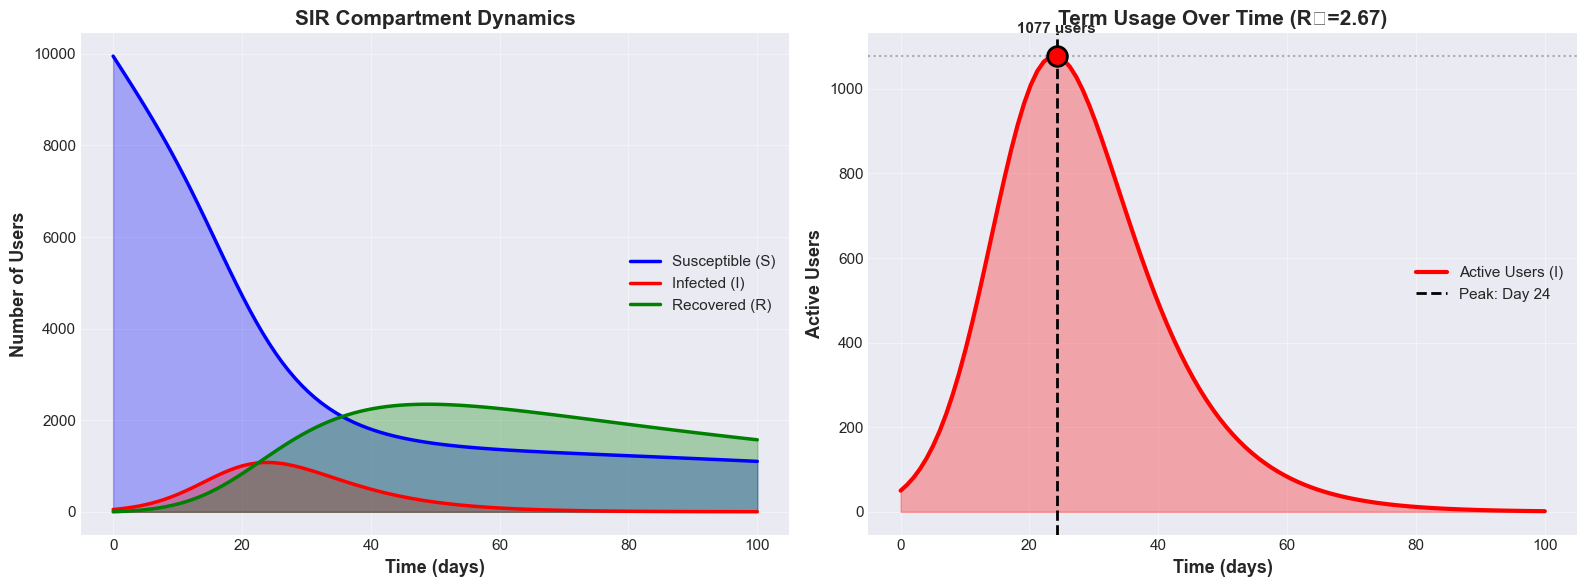


✓ Peak usage occurs at Day 24 with 1077 active users


In [ ]:


print("""
🧬 SIR FRAMEWORK:
   We divide the user population into three compartments:
   
   S (Susceptible) - Users who haven't adopted the term yet
   I (Infected)    - Users actively using the term
   R (Recovered)   - Users who stopped using the term

📐 MATHEMATICAL MODEL (from our proposal):

   Equation 1:  dS/dt = -βSI - μS + γR
   Equation 2:  dI/dt = βSI - αI - νI
   Equation 3:  dR/dt = αI - γR

🔧 PARAMETERS:
   β (beta)  - Transmission rate (how quickly term spreads)
   α (alpha) - Recovery rate (how fast users stop using it)
   ν (nu)    - Mutation rate (semantic change)
   μ (mu)    - Birth rate (new users joining platform)
   γ (gamma) - Re-susceptibility rate (users becoming susceptible again)

📏 KEY METRIC:
   R₀ = β / (α + ν)  [Basic Reproduction Number]
   
   If R₀ > 1 → Term will GO VIRAL ✓
   If R₀ < 1 → Term will DIE OUT ✗
""")

# Demonstrate SIR equations with a simple example
print("\n🔬 DEMONSTRATING SIR DYNAMICS:")
print("-" * 70)

# Create simple example
example_model = LinguisticContagionModel(
    SIRParameters(beta=0.4, alpha=0.1, nu=0.05, mu=0.02, gamma=0.01)
)

N_example = 10000  # Population
I0_example = 50    # Initial users

history = example_model.simulate(I0=I0_example, N=N_example, t_max=100)
R0 = example_model.calculate_R0()

print(f"\nExample Scenario:")
print(f"  • Population: {N_example:,} users")
print(f"  • Initial adopters: {I0_example}")
print(f"  • Transmission rate (β): {example_model.params.beta}")
print(f"  • Recovery rate (α): {example_model.params.alpha}")
print(f"  • R₀: {R0:.2f}")
print(f"  • Prediction: {'VIRAL (will spread)' if R0 > 1 else 'Will not spread'}")

# Plot example dynamics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: All compartments
ax1.plot(history['t'], history['S'], 'b-', linewidth=2.5, label='Susceptible (S)')
ax1.plot(history['t'], history['I'], 'r-', linewidth=2.5, label='Infected (I)')
ax1.plot(history['t'], history['R'], 'g-', linewidth=2.5, label='Recovered (R)')
ax1.fill_between(history['t'], history['S'], alpha=0.3, color='blue')
ax1.fill_between(history['t'], history['I'], alpha=0.3, color='red')
ax1.fill_between(history['t'], history['R'], alpha=0.3, color='green')
ax1.set_xlabel('Time (days)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Number of Users', fontsize=13, fontweight='bold')
ax1.set_title('SIR Compartment Dynamics', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11, loc='right')
ax1.grid(True, alpha=0.4)

# Right: Focus on infected
peak_idx = history['I'].idxmax()
peak_time = history.loc[peak_idx, 't']
peak_val = history.loc[peak_idx, 'I']

ax2.plot(history['t'], history['I'], 'r-', linewidth=3, label='Active Users (I)')
ax2.axvline(peak_time, color='black', linestyle='--', linewidth=2, 
            label=f'Peak: Day {peak_time:.0f}')
ax2.axhline(peak_val, color='gray', linestyle=':', alpha=0.6)
ax2.scatter([peak_time], [peak_val], color='red', s=200, zorder=5, 
            edgecolors='black', linewidths=2)
ax2.fill_between(history['t'], history['I'], alpha=0.3, color='red')
ax2.set_xlabel('Time (days)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Active Users', fontsize=13, fontweight='bold')
ax2.set_title(f'Term Usage Over Time (R₀={R0:.2f})', fontsize=15, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.4)
ax2.text(peak_time, peak_val*1.05, f'{peak_val:.0f} users', 
         ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Peak usage occurs at Day {peak_time:.0f} with {peak_val:.0f} active users")

# 3. Data Preprocessing for Reddit/Twitter

In [6]:
DATA_FILE = 'reddit_data.csv'  
PLATFORM = 'reddit'            

print(f"\n📂 Configuration:")
print(f"   • Data file: {DATA_FILE}")
print(f"   • Platform: {PLATFORM}")
print(f"   • Min term length: {preprocessor.min_term_length}")
print(f"   • Min frequency: {preprocessor.min_frequency}")

# Try to load data
try:
    print(f"\n🔄 Loading data from {DATA_FILE}...")
    df = preprocessor.load_csv(DATA_FILE, platform=PLATFORM)
    
    summary = preprocessor.get_summary()
    
    print(f"\n✓ Data loaded successfully!")
    print(f"\n📊 DATASET SUMMARY:")
    print(f"   • Total posts: {summary['total_posts']:,}")
    print(f"   • Date range: {summary['date_range']['start'].date()} to {summary['date_range']['end'].date()}")
    print(f"   • Duration: {summary['date_range']['days']} days")
    if 'unique_users' in summary:
        print(f"   • Unique users: {summary['unique_users']:,}")
    if 'unique_communities' in summary:
        print(f"   • Communities: {summary['unique_communities']:,}")
    print(f"   • Avg text length: {summary['avg_text_length']:.1f} characters")
    
    # Show sample
    print(f"\n📝 SAMPLE POSTS:")
    print("-" * 70)
    sample_df = df[['timestamp', 'text']].head(3)
    for idx, row in sample_df.iterrows():
        print(f"\n[{row['timestamp']}]")
        print(f"{row['text'][:150]}..." if len(row['text']) > 150 else row['text'])
    
    DATA_LOADED = True
    
except FileNotFoundError:
    print(f"\n⚠️  WARNING: Data file not found: {DATA_FILE}")
    print("\n💡 TO USE YOUR OWN DATA:")
    print("   1. Update DATA_FILE variable above with your CSV path")
    print("   2. Ensure CSV has 'text' and 'timestamp' columns")
    print("   3. Re-run this cell")
    print("\n📖 For now, we'll use synthetic data for demonstration...")
    
    DATA_LOADED = False
    
    # Create synthetic data for demonstration
    np.random.seed(42)
    dates = pd.date_range('2023-01-01', periods=100, freq='D')
    synthetic_counts = np.random.poisson(lam=20, size=100)
    synthetic_counts[30:60] = synthetic_counts[30:60] * 3  # Create a peak
    
    time_series = pd.Series(synthetic_counts, index=dates)
    SELECTED_TERM = "example_term"
    N = 50000
    
    print("✓ Using synthetic data for demonstration")


📂 Configuration:
   • Data file: reddit_data.csv
   • Platform: reddit


NameError: name 'preprocessor' is not defined

# 4. TERM DETECTION


In [ ]:
# Term Detection Code 

# 5. SIR MODEL FITTING


In [ ]:
print(f"\n🔄 Fitting SIR model to '{SELECTED_TERM}' data...")

# Initialize and fit model
model = LinguisticContagionModel()

try:
    fitted_params = model.fit_to_data(time_series, population=N)
    
    print("\n✓ Model fitting completed successfully!")
    
    print(f"\n⚙️  FITTED PARAMETERS:")
    print("-" * 70)
    print(f"{'Parameter':<25} {'Value':<12} {'Interpretation'}")
    print("-" * 70)
    print(f"{'β (Transmission Rate)':<25} {fitted_params.beta:<12.4f} How fast term spreads")
    print(f"{'α (Recovery Rate)':<25} {fitted_params.alpha:<12.4f} How fast users stop using it")
    print(f"{'ν (Mutation Rate)':<25} {fitted_params.nu:<12.4f} Semantic drift rate")
    print(f"{'μ (Birth Rate)':<25} {fitted_params.mu:<12.4f} New user influx")
    print(f"{'γ (Re-susceptibility)':<25} {fitted_params.gamma:<12.4f} Users become susceptible again")
    
    R0 = model.calculate_R0()
    print("\n" + "=" * 70)
    print(f"🔬 R₀ (BASIC REPRODUCTION NUMBER): {R0:.3f}")
    print("=" * 70)
    
    if R0 > 1:
        print(f"✓ VIRAL PREDICTION: This term WILL SPREAD (R₀ = {R0:.2f} > 1)")
        print(f"  Each user will, on average, transmit the term to {R0:.2f} others")
    else:
        print(f"✗ NON-VIRAL: This term will NOT spread significantly (R₀ = {R0:.2f} < 1)")
    
    FITTING_SUCCESS = True
    
except Exception as e:
    print(f"\n⚠️  Fitting failed: {e}")
    print("Using default parameters for demonstration...")
    fitted_params = SIRParameters(beta=0.3, alpha=0.1, nu=0.05, mu=0.02, gamma=0.01)
    model.params = fitted_params
    FITTING_SUCCESS = False

NameError: name 'SELECTED_TERM' is not defined

# 6. MODEL SIMULATION AND RESULTS

In [ ]:
#code

# 7 MODEL EVALUATION 

In [ ]:
#code 